# Проект 7. Классификация

### Бизнес-задача: 
Определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

### Техническая задача:
Построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

МОИ ЦЕЛИ:

1) Исследовать данные.

2) Выявить характерные черты для потенциальных клиентов, чтобы чётко очертить ЦА и увеличить прибыль банка.

3) Использовать разные инструменты для повышения качества прогноза.

In [2]:
# импортирую необходимые для работы библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [3]:
# загружаю данные

df = pd.read_csv('bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Данные о клиентах банка:

age (возраст);

job (сфера занятости);

marital (семейное положение);

education (уровень образования);

default (имеется ли просроченный кредит);

housing (имеется ли кредит на жильё);

loan (имеется ли кредит на личные нужды);

balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

contact (тип контакта с клиентом);

month (месяц, в котором был последний контакт);

day (день, в который был последний контакт);

duration (продолжительность контакта в секундах).

Прочие признаки:

campaign (количество контактов с этим клиентом в течение текущей кампании);

pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);

previous (количество контактов до текущей кампании)

poutcome (результат прошлой маркетинговой кампании).

In [4]:
# исследую данные на предмет пропусков

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Явные пропуски обнаружены в признаке баланс. Отсутствует 25 значений.

### Задание 2

In [5]:
# исследую признак job на предмет скрытых пропусков

df.groupby('job')['age'].count()

job
admin.           1334
blue-collar      1944
entrepreneur      328
housemaid         274
management       2566
retired           778
self-employed     405
services          923
student           360
technician       1823
unemployed        357
unknown            70
Name: age, dtype: int64

В признаке job оказались неявные пропуски, заполненные словом unknown.

### Задание 3

In [6]:
# преобразовываю признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
# удаляю все ненужные символы
df['balance'] = df['balance'].str.replace(' ', '')
df['balance'] = df['balance'].str.replace('$', '')
df['balance'] = df['balance'].str.replace(',00', '')

# меняю тип данный признака
df['balance'] = df['balance'].astype(float)

### Задание 4

In [7]:
# обрабатываю пропуски в признаке balance, заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

### Задание 5

In [8]:
# обрабатываю пропуски в категориальных признаках: job и education, заменив их на модальные значения
# узнаю модальное значение в признаке job
print(df['job'].describe())

count          11162
unique            12
top       management
freq            2566
Name: job, dtype: object


In [9]:
# заменяю пропуски на модальное значение management          
df['job'] = df['job'].replace('unknown', 'management')

# проверяю
print(df.groupby('job')['age'].count())  

job
admin.           1334
blue-collar      1944
entrepreneur      328
housemaid         274
management       2636
retired           778
self-employed     405
services          923
student           360
technician       1823
unemployed        357
Name: age, dtype: int64


In [10]:
# узнаю, каким значением заполены пропуски в признаке education сейчас
print(df.groupby('education')['age'].count()) 

education
primary      1500
secondary    5476
tertiary     3689
unknown       497
Name: age, dtype: int64


In [11]:
# узнаю модальное значение в признаке education
print(df['education'].describe())

count         11162
unique            4
top       secondary
freq           5476
Name: education, dtype: object


In [12]:
# заменяю пропуски на модальное значение management          
df['education'] = df['education'].replace('unknown', 'secondary')

# проверяю
print(df.groupby('education')['age'].count())  

education
primary      1500
secondary    5973
tertiary     3689
Name: age, dtype: int64


In [13]:
# рассчитываю средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования
# делаю копию данных
df_copy = df.copy()

# фильтрую столбцы, вывожу среднее по балансу
df_copy =  df_copy[df_copy['job'] == 'management']
df_copy = df_copy[df_copy['education'] == 'secondary']
df_copy['balance'].mean().round()


1599.0

### Задание 6

In [14]:
# ищу выбросы по методу Тьюки
# нахожу 25 и 75 процентили
q_25 = np.percentile(a = df['balance'], q = 25)
q_75 = np.percentile(a = df['balance'], q = 75)

In [15]:
# нахожу межквартальный размах
mp = q_75 - q_25

#вычисляю верхнюю и нижнюю границы
lower_bound = q_25 - (mp*1.5)
upper_bound = q_75 + (mp*1.5)

# фильтрую датасет по найденным границам (удаляю выбросы)
df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


## Часть 2:  Разведывательный анализ

### Задание 1

no     0.54
yes    0.46
Name: deposit, dtype: float64

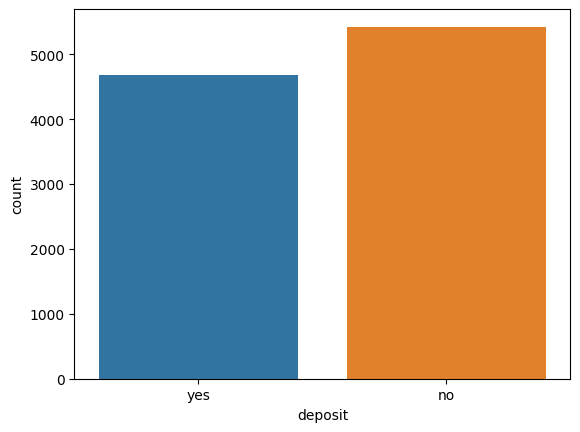

In [16]:
# изучаю соотношение классов в данных на предмет несбалансированности
sns.countplot(data=df, x = 'deposit')

df['deposit'].value_counts(normalize=True).round(2)

Целевой признак близок к балансу. Соотношение классов 54% и 46%

### Задания 2 и 3

In [17]:
# описательные статистики для количественных переменных

df.describe(include='int64')

,age,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


count    10105.000000
mean       807.653538
std        994.151966
min      -2049.000000
25%         95.000000
50%        445.000000
75%       1227.000000
max       4063.000000
Name: balance, dtype: float64

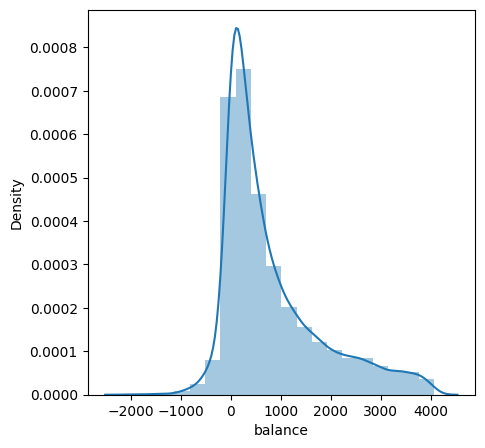

In [18]:
# рассмотрю признак баланса
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
mean_barplot = sns.distplot(df['balance'], bins=20)

df['balance'].describe()

Первое, что бросается в глаза - клиенты с отрицательным балансом, а так же большое количество клиентов с нулевым балансом ()

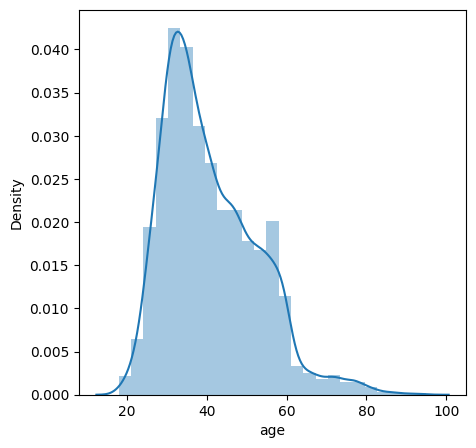

In [19]:
# рассмотрю признак возраста

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
mean_barplot = sns.distplot(df['age'], bins=25)

Большинство наблюдаемых клиентов в возрасте от 25 до 40 лет. После 60 же лет идёт резкое снижение количества клиентов.

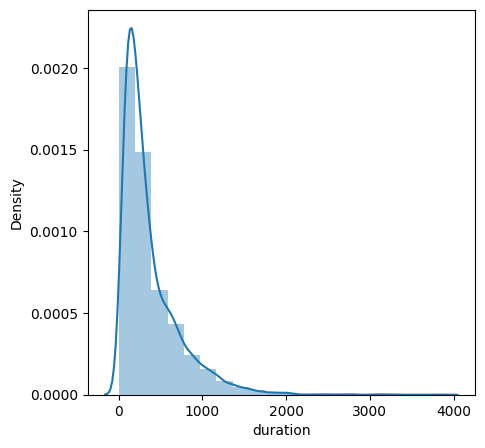

In [20]:
# рассмотрю признак продолжительности контакта с клиентом

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
mean_barplot = sns.distplot(df['duration'], bins=20)

Наблюдается медиана 252 секунды, а так же хорошо видно, что продолжительные (более 500 секунд) разговоры, довольно редки. Интересно проверить взаимосвязь длины разговора и наличия депозита.

Text(0, 0.5, 'Баланс')

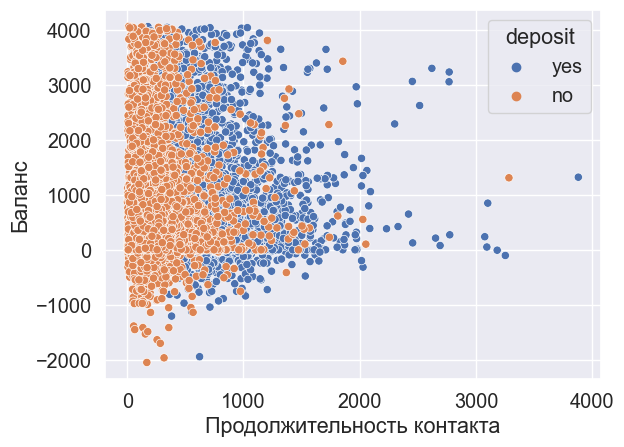

In [21]:
# иллюстрирую взаимосвязь длительности разговора и целевой переменной
sns.set(font_scale=1.3)
sns.scatterplot(
    x='duration', 
    y='balance', 
    data=df,
    hue='deposit')
plt.xlabel(
    'Продолжительность контакта')
plt.ylabel(
    'Баланс')

Из графика вижу, что есть некая зависимось продолжительности контакта с клиентом и наличия депозита. 

Чаще всего, разговоры, которые заканчивались раньше 500-600 секунд, не приводили к открытию депозита клиентом.

### Задания 4 и 5

In [22]:
# описательные статистики для категориальных переменных

df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


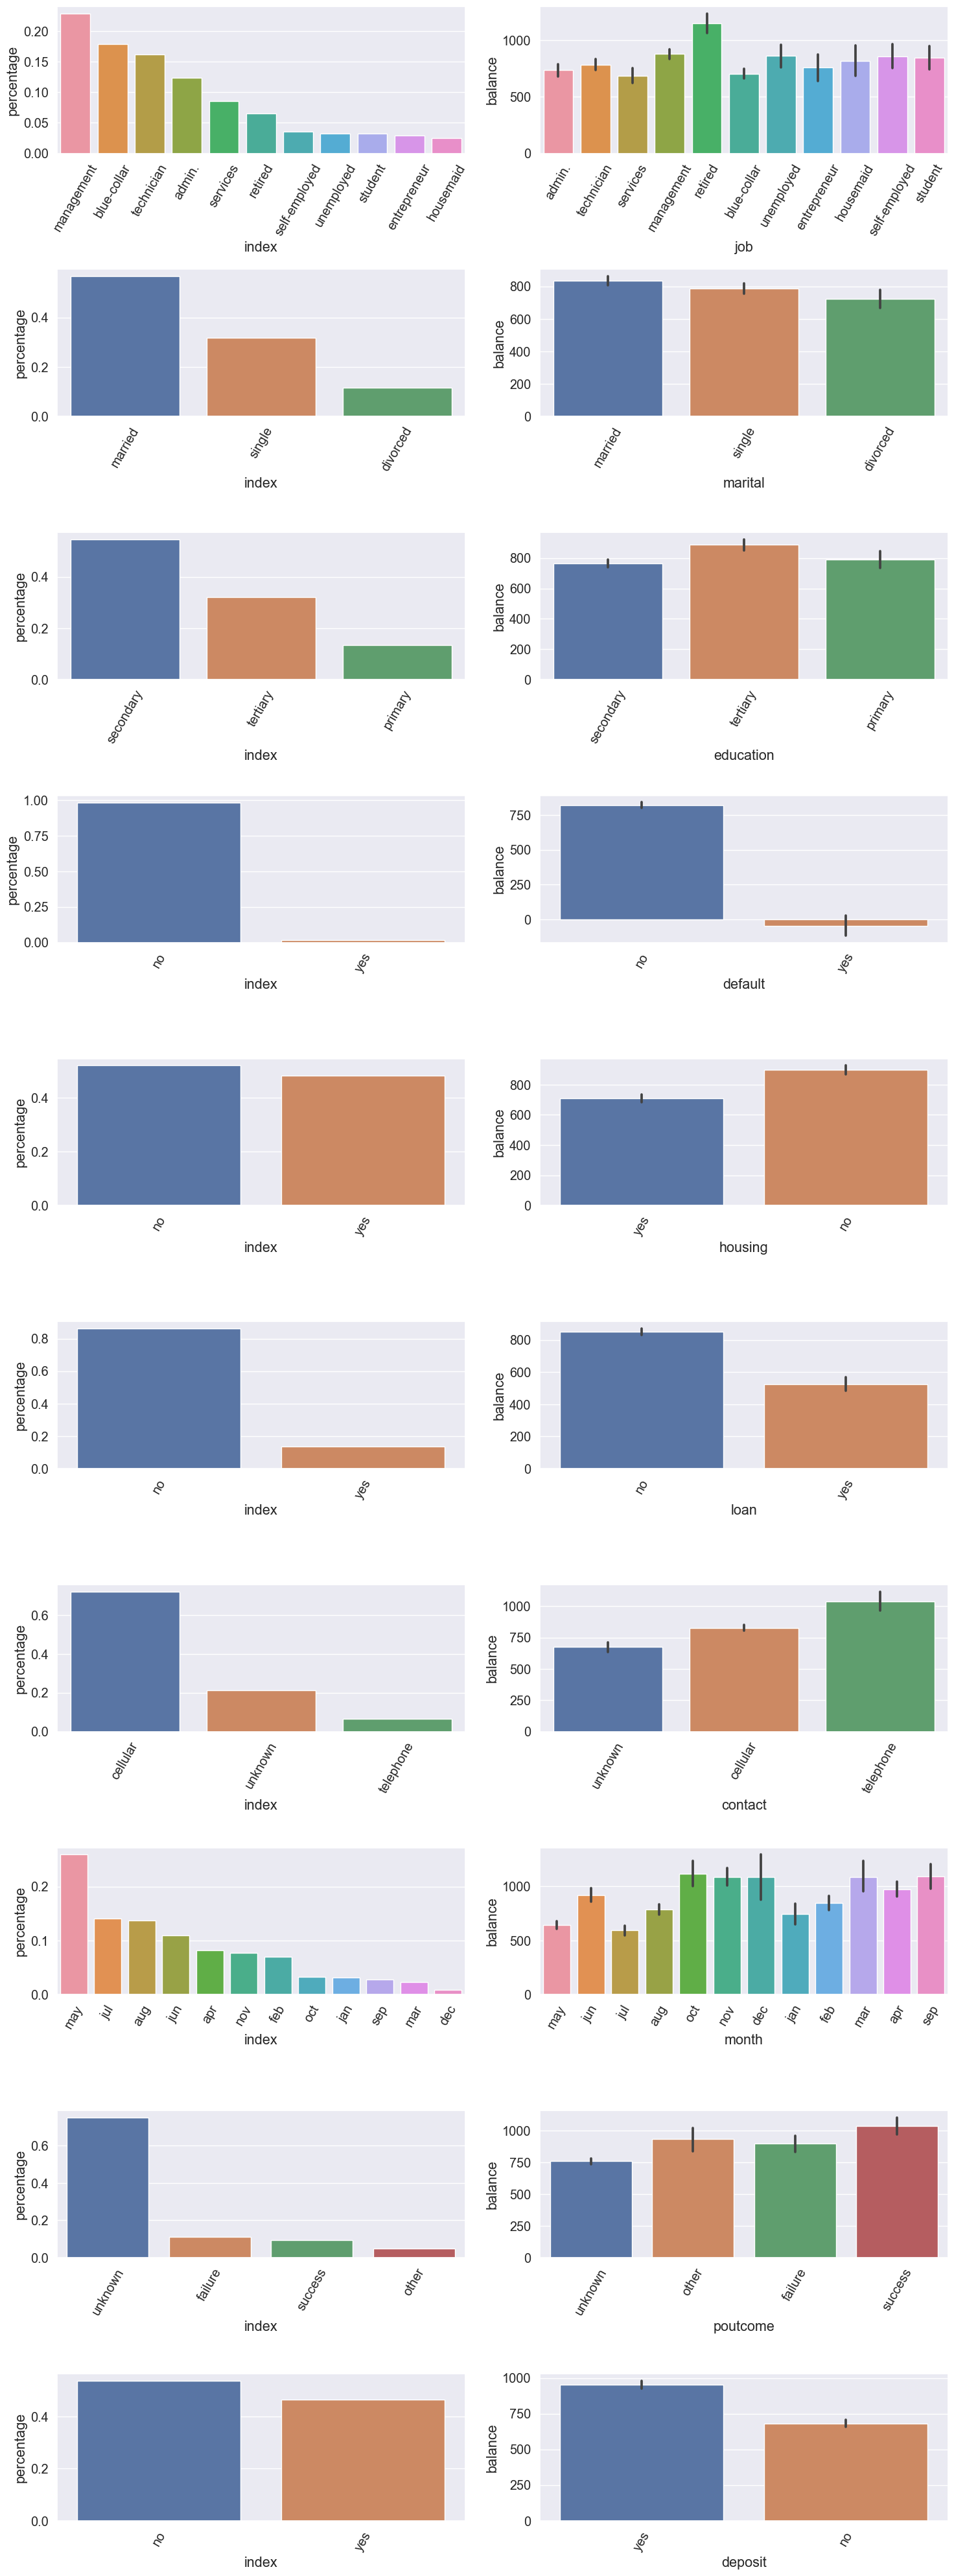

In [23]:
types = df.dtypes
cat_features = list(types[(types == 'object')].index)

n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму баланса клиента в зависимости от категории
    mean_barplot = sns.barplot(data=df, x=feature, y='balance', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout()

Из визуализации категориальных переменных в заррезе баланса стало известно:

1) Чаще всего рассматривались клиенты с профессиями management, blue-collar, technican. Но при этом, количество денег на счету выше 1000 долларов только у retrited. 

Остальные профессии не превышают баланса на счетах выше 900 долларов.

2) Большинство клиентов находятся в браке и при этом, на их счетах находится больше накоплений (хорть и не на много), чем у клиентов в разводе и одиноких.

3) Больше половины клиентов имеют среднее образование, но при этом бОльшие балансы имеют клиенты с высшим образованием.

4) Просроченные кредиты имеются у малой части клиентов и при этом их балансы чаще отрицательные.

5) Кредит на жильё имеется чуть меньше, чем у половины рассматриваемых клиентов. Балансы клиентов с ипотекой немногим ниже, чем без неё.

6) Потребительский кредит имеют около 10% клиентов банка, и баланс на счетах этих клиентов не превышает 600 долларов, это значительно ниже клиентов, не обремененных данным кредитом.

7) Контакт с клиентом чаще всего происходил по мобильному телефону, а вот балансы при этом выше у клиентов, вступивших в контакт с банком по городскому телефону.

8) Последний контакт, в наших данных, был чаще всего в мае. Но балансы клиентов, с которыми в мае общались - самые низкие. 

Чаще всего высокие балансы наблюдаются у клиентов, с которыми контактировали в последний раз в октябре, ноябре, декабре и марте.

9) Результат последней компании однозначно оценить сложно, тк более 70% данных не зафиксировано. 

Но при этом явно видно, что успешный результат компании влияет на балансы клиентов, хоть и не много.

10) Целево признак депозита, как и говорилось ранее, правтически сбалансирован. 

Если обратить внимание на балансы пользователей, то явно видно, что у клиентов, которые внесли депозит балансы в среднем выше 900 долларов, когда как

в противном случае, не превышают 700 долларов.

### Задание 6

In [24]:
# Узнаю, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач

suc = df.groupby('poutcome')['deposit'].count()
print(suc)

poutcome
failure    1109
other       481
success     945
unknown    7570
Name: deposit, dtype: int64


### Задание 7

In [25]:
# узнаю, в каком месяце чаще всего отказывались от предложения открыть депозит

mont_no = df.groupby(['month'])['deposit'].value_counts(normalize=True).unstack()
print(mont_no.sort_values(by='no', ascending=False))

deposit        no       yes
month                      
may      0.678640  0.321360
jan      0.608150  0.391850
jul      0.589563  0.410437
nov      0.584615  0.415385
aug      0.559567  0.440433
jun      0.548913  0.451087
feb      0.455571  0.544429
apr      0.381928  0.618072
oct      0.185075  0.814925
sep      0.165468  0.834532
mar      0.101266  0.898734
dec      0.096774  0.903226


В мае чаще всего отказывались от предложения открыть депозит

### Задание 8

<AxesSubplot: xlabel='age_cat', ylabel='count'>

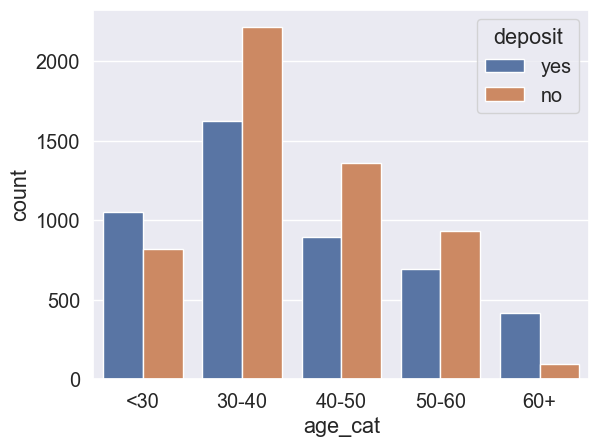

In [26]:
# создаю возрастные группы и определяю, в каких группах более склонны открывать депозит, чем отказываться от предложения

df['age_cat'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_cat", hue="deposit", data=df)

### Задания 9 и 10

<AxesSubplot: xlabel='count', ylabel='marital'>

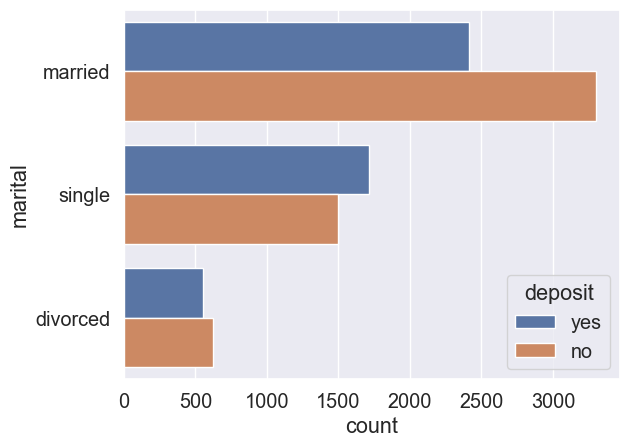

In [27]:
# визуализация для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(y='marital', hue='deposit', data=df)

<AxesSubplot: xlabel='count', ylabel='education'>

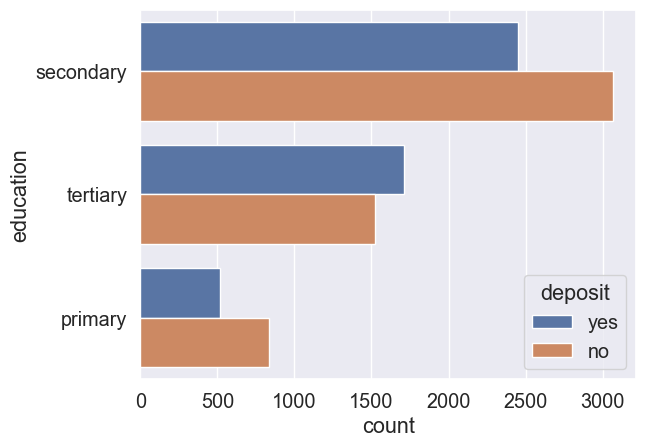

In [28]:
# визуализация для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(y="education", hue="deposit", data=df)

<AxesSubplot: xlabel='count', ylabel='job'>

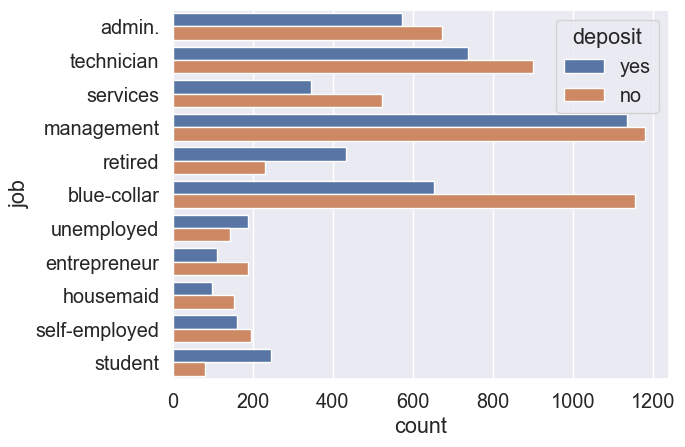

In [29]:
# визуализация для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(y="job", hue="deposit", data=df)

### Задание 11

In [30]:
# строю сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны

df_1 = df[df['deposit'] == 'yes'] # фильтрую данные
df_2 = df[df['deposit'] == 'no']

pivot1 = df_1.groupby(['marital', 'education'])['deposit'].count().unstack() # группирую
pivot2 = df_2.groupby(['marital', 'education'])['deposit'].count().unstack()
print('Сводная таблица для отказавшихся от депозита')
print(pivot2)
print()
print('Сводная таблица для получивших депозит')
print(pivot1)


Сводная таблица для отказавшихся от депозита
education  primary  secondary  tertiary
marital                                
divorced        91        370       163
married        641       1830       832
single         100        866       531

Сводная таблица для получивших депозит
education  primary  secondary  tertiary
marital                                
divorced        96        283       174
married        339       1289       784
single          82        879       755


<AxesSubplot: xlabel='education', ylabel='marital'>

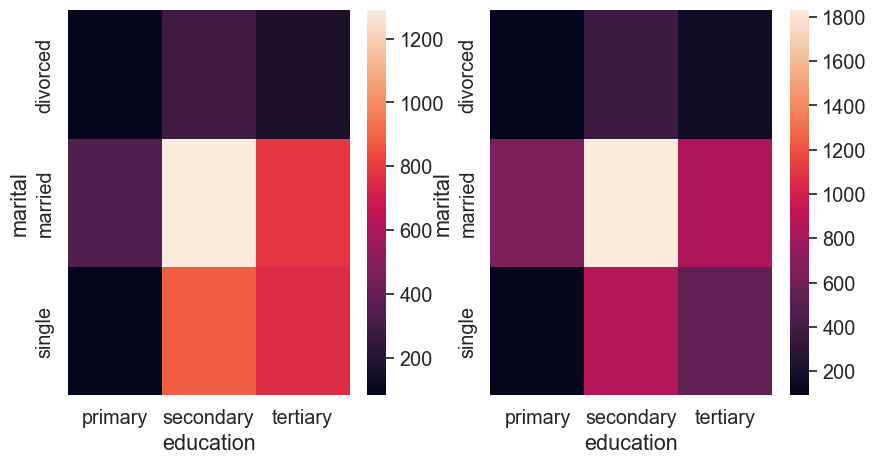

In [31]:
# построю тепловые карты

fig, axes = plt.subplots(1,2, figsize=(10, 5))
sns.heatmap(pivot1, ax=axes[0])
sns.heatmap(pivot2, ax=axes[1])

Самым многочисленным пересечением оказались Married и Secondary, не зависимо от целевой переменной.

## Часть 3: преобразование данных

### Задание 1

In [32]:
# преобразую уровни образования

lbl = preprocessing.LabelEncoder()
lbl.fit(list(df['education'].values.astype('str')))
df['education'] = lbl.transform(list(df['education'].values.astype('str')))

lbl.fit(list(df['age_cat'].values.astype('str')))
df['age_cat'] = lbl.transform(list(df['age_cat'].values.astype('str')))


### Задания 2 и 3

In [52]:
# преобразуйю бинарные переменные в представление из нулей и единиц

df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)


### Задание 4

In [34]:
# создаю дамми-переменные

df_dum = df[['job', 'marital', 'contact', 'month', 'poutcome']]
dummies_ = pd.get_dummies(df_dum)
df = pd.concat([df, dummies_], axis=1)

df

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
1,56,admin.,married,1,0,45.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
2,41,technician,married,1,0,1270.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
4,54,admin.,married,2,0,184.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,0,0,1.0,1,0,cellular,20,...,0,0,0,0,0,0,0,0,0,1
11158,39,services,married,1,0,733.0,0,0,unknown,16,...,1,0,0,0,0,0,0,0,0,1
11159,32,technician,single,1,0,29.0,0,0,cellular,19,...,0,0,0,0,0,0,0,0,0,1
11160,43,technician,married,1,0,0.0,0,1,cellular,8,...,0,0,1,0,0,0,1,0,0,0


### Задания 5 и 6

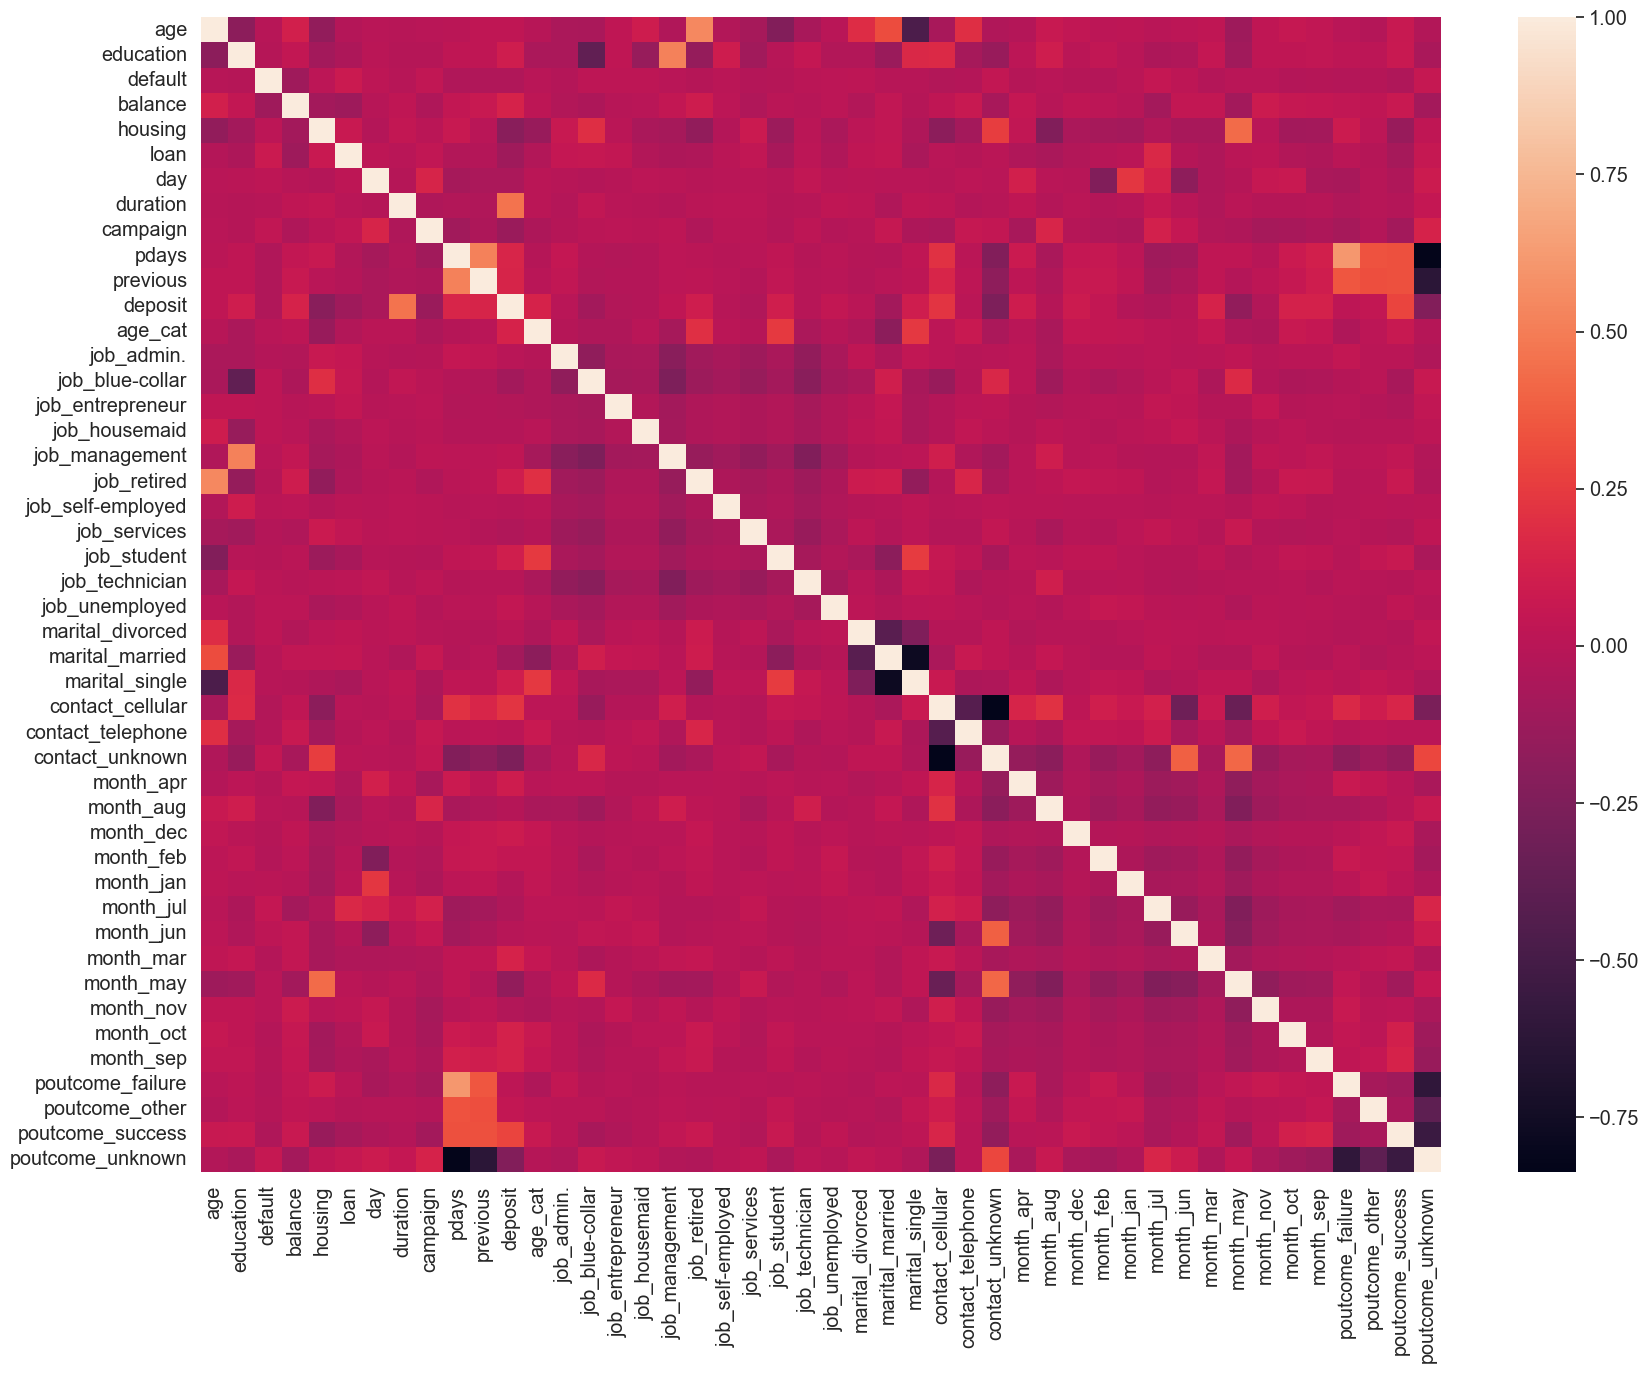

In [35]:
# корреляционная матрицаб проверяю данные на предмет наличия мультиколлинеарности

plt.figure(figsize = (20, 15))
sns.heatmap(df.corr(), fmt='.2f');

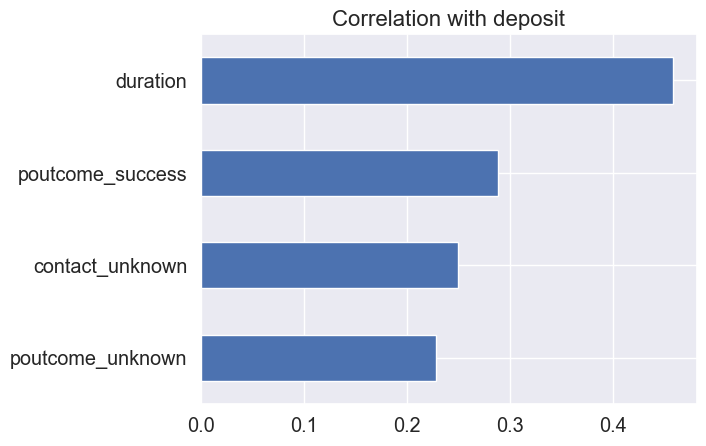

In [36]:
# строю столбчатую диаграмму корреляции с deposit

corr = df.corr()

corr["deposit"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

### Задания 7 и 8

In [37]:
# удаляю оставшиеся после преобразований нечисловые признаки
df = df.drop(['job', 'marital', 'contact', 'month', 'poutcome', 'age'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   education          10105 non-null  int32  
 1   default            10105 non-null  int64  
 2   balance            10105 non-null  float64
 3   housing            10105 non-null  int64  
 4   loan               10105 non-null  int64  
 5   day                10105 non-null  int64  
 6   duration           10105 non-null  int64  
 7   campaign           10105 non-null  int64  
 8   pdays              10105 non-null  int64  
 9   previous           10105 non-null  int64  
 10  deposit            10105 non-null  int64  
 11  age_cat            10105 non-null  int32  
 12  job_admin.         10105 non-null  uint8  
 13  job_blue-collar    10105 non-null  uint8  
 14  job_entrepreneur   10105 non-null  uint8  
 15  job_housemaid      10105 non-null  uint8  
 16  job_management     101

In [38]:
# подготавливаю дата сет к моделированию
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 9

In [39]:
# с помощью SelectKBest отбераю 15 наиболее подходящих признаков

KBest = SelectKBest(k=15, score_func = f_classif)
KBest.fit_transform(X_train, y_train)

KBest.get_feature_names_out()
new = list(KBest.get_feature_names_out())
X_test = X_test[new]
X_train = X_train[new]
new

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_cat',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [40]:
# нормализую данные с помощью minmaxsxaler

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
x_train_scaled = scaler.transform(X_train)
x_test_scaled = scaler.transform(X_test)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [41]:
# обучаю логистическую регрессию и рассчитываю метрики качества

log_reg = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_reg.fit(x_train_scaled, y_train)
pred_train = log_reg.predict(x_train_scaled)
pred_test = log_reg.predict(x_test_scaled)

print('Метрика accuracy на тестовой выборке', metrics.accuracy_score( y_test, pred_test).round(2))

Метрика accuracy на тестовой выборке 0.81


### Задания 2,3,4

In [42]:
# обучаю решающие деревья, настраиваю максимальную глубину

tree_1 = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)
tree_1.fit(x_train_scaled, y_train)
pred_test = tree_1.predict(x_test_scaled)
pred_train = tree_1.predict(x_train_scaled)

print('accuracy на тренировочной выборке',metrics.accuracy_score(y_train, pred_train).round(2))
print('accuracy на тестовой выборке', metrics.accuracy_score(y_test, pred_test).round(2))

accuracy на тренировочной выборке 0.82
accuracy на тестовой выборке 0.81


### Задание 5

In [43]:
# подбираю оптимальные параметры с помощью gridsearch

from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth': [3,5,7]
              }
# использую метод            
grid_search = GridSearchCV(tree.DecisionTreeClassifier(random_state=42),param_grid,cv=3, scoring=('f1'), return_train_score=True) 
 
grid_search.fit(x_train_scaled, y_train) 

# вывожу метрику
y_test_pred = grid_search.predict(x_test_scaled)
print('Метрика f1 на тестовом наборе: ', metrics.f1_score(y_test, y_test_pred).round(2))
print('Наилучшие значения гиперпараметров: ', grid_search.best_params_)



Метрика f1 на тестовом наборе:  0.8
Наилучшие значения гиперпараметров:  {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [44]:
# обучаю случайный лес

rf_model = ensemble.RandomForestClassifier(
    n_estimators = 100, 
    criterion = 'gini', 
    min_samples_leaf = 5, 
    max_depth = 10, 
    random_state = 42
    )

rf_model.fit(x_train_scaled, y_train)

pred_test = rf_model.predict(x_test_scaled)

print(metrics.classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [45]:
# использую для классификации градиентный бустинг и сравниваю качество со случайным лесом

from sklearn.ensemble import GradientBoostingClassifier

# Создаем объект класса градиентный бустинг
gb = GradientBoostingClassifier(
    max_depth = 5, 
    n_estimators = 300, 
    random_state = 42,
    min_samples_leaf = 5,
    learning_rate = 0.05
)

# Обучаем модель
gb.fit(x_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
gb_pred  = gb.predict(x_test_scaled)

# Оцениваем качество по метрике MSE
print('Метрика f1', metrics.f1_score(y_test, gb_pred).round(2))


Метрика f1 0.82


### Задание 4

In [46]:
# объедининяю алгоритмы с помощью стекинга 

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Создаю список кортежей вида: (наименование модели, модель)
estimators = [
    ('dtc', DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)),
    ('lr', LogisticRegression(random_state=42, solver='sag', max_iter=1000)),
    ('gb', GradientBoostingClassifier(max_depth = 5, n_estimators = 300, random_state = 42,min_samples_leaf = 5,learning_rate = 0.05))
]

# Создаю объект класса стекинг
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
)

stack.fit(x_train_scaled, y_train)

pred_test = stack.predict(x_test_scaled)

print('Precision на тестовой выборке', metrics.precision_score(y_test, pred_test).round(2))



Precision на тестовой выборке 0.81


### Задание 5

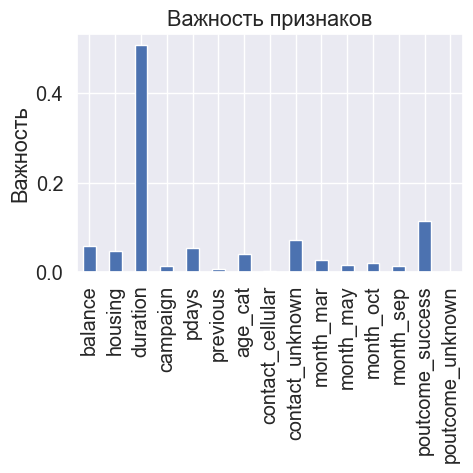

In [47]:
# оцениваю, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

importance = pd.Series(gb.feature_importances_,
                         df[new].columns)

fig, ax = plt.subplots(figsize=(5,5))
importance.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

### Задания 6,7,8

In [48]:
# реализовываю оптимизацию гиперпараметров с помощью Optuna
import optuna

def optuna_rf(trial):
  # задаю пространство поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  model.fit(x_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(x_train_scaled))

  return score

In [49]:
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

[I 2023-10-22 18:14:26,047] A new study created in memory with name: RandomForestClassifier
[I 2023-10-22 18:14:26,838] Trial 0 finished with value: 0.849460684695951 and parameters: {'n_estimators': 162, 'max_depth': 14, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.849460684695951.
[I 2023-10-22 18:14:27,843] Trial 1 finished with value: 0.8595558335939943 and parameters: {'n_estimators': 183, 'max_depth': 13, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8595558335939943.
[I 2023-10-22 18:14:28,762] Trial 2 finished with value: 0.845778965571451 and parameters: {'n_estimators': 197, 'max_depth': 10, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8595558335939943.
[I 2023-10-22 18:14:29,626] Trial 3 finished with value: 0.8917057902973397 and parameters: {'n_estimators': 136, 'max_depth': 22, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8917057902973397.
[I 2023-10-22 18:14:30,793] Trial 4 finished with value: 0.8991662733994022 and parameters: {'n_est

In [50]:
# вывожу результаты на обучающей выборке

print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 162, 'max_depth': 25, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.93


In [51]:
# рассчитываю точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(x_train_scaled, y_train)
y_train_pred = model.predict(x_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(x_test_scaled, y_test)))
y_test_pred = model.predict(x_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82


Вывод:

Наилучшие значения метрик были замечены при использовании RandomForestClassifier при реализации оптимизации гиперпараметров с помощью Optuna